# Simulating wiring rules in silico

We use a digital model of one cortical column of the rat barrel cortex to simulate the effect of different wiring rules on the connectome. In turn, we compare summary statistics on the simulated connectome to real measurements to test the plausibility of the wiring rule. 

The wiring rules have free parameters. To identify those parameters that are likely to reproduce the measured connectivity in silico, we perform Bayesian parameter inference using simulation-based inference (SBI). 

The wiring rule simulator is implemented in this repository. 
The code for performing SBI comes from a separate package, the `SBI package`: https://github.com/mackelab/sbi

## The structural model of the rat barrel cortex

The structural model consists of structural features of neurons in the barrel cortex. 
The model contains only the features of the neurons and no connections.
The connections are introduced only by applying a wiring rule to the structural features. 

The model is implemented in the `consbi` package. 
The package contains several classes that take care of all the steps required for applying a wiring rule to the model, and many different functions representing different wiring rules. 
For example, the `RuleSimulator` class allows to simulate many variations of the dense structural overlap (DSO) rule presented in the paper; 
the `DistanceRuleSimulator` class allows to the simulator distance-based rules like we used in the second part of the paper. 

### Simplified model for evaluation
We used a simplified version of the structural model to evaluate our approach. 
The simplified version contains only a small number of neurons and features and is therefore fast to simulate. 
Additionally, there are no summary statistics involved such that simulating new connections corresponds to just sampling from a Poisson distribution (see Methods & Materials for details). 
This version of the wiring rule simulator is represented by the `poisson_glm` function. 

In [36]:
str(BASE_PATH.joinpath("figures/plotting_settings.mplstyle"))

'/home/janfb/qode/sbi-for-connectomics/figures/plotting_settings.mplstyle'

In [37]:
import numpy as np
import pickle

from consbi.simulators import DistanceRuleSimulator, RuleSimulator, poisson_glm, peters_rule_subcellular
from consbi.simulators import default_rule
from torch.distributions import MultivariateNormal

from sbi.inference import prepare_for_sbi, simulate_for_sbi
from sbi.utils import BoxUniform

import torch
import matplotlib.pyplot as plt

from consbi import DATA_PATH, RESULTS_PATH, BASE_PATH

plt.style.use(str(BASE_PATH.joinpath("figures/plotting_settings.mplstyle")))
%matplotlib inline

## Simulating data
To simulate connectivity data we need 
- a simulator class, 
- a wiring rule with free parameters and 
- a prior distribution over the parameters.

Below, we start with simulating data from the DSO rule (called `default_rule` in the code). The DSO rule was used as the main example shown in the paper. 

In [39]:
# the structural features of the model are saved to disk. specify the path:
path_to_model = str(BASE_PATH.joinpath("data/structural_model"))

# set number of neuron pairs sampled from the connectome to mimick experimental settings, e.g., 50
num_subsampling_pairs = 50

# set the default rule as wiring rule (DSO)
simulator = RuleSimulator(path_to_model, 
                          default_rule, 
                          verbose=True, 
                          num_subsampling_pairs=num_subsampling_pairs)

Loading features, this may take a while...
Time elapsed: 155.66546773910522


/home/janfb/qode/sbi-for-connectomics/consbi/simulators/rule_simulator.py:657: RuntimeWarning: invalid value encountered in log
  log_features = np.log(features)


constraint 0, num rows (with overlap) 2168393
constraint 1, num rows (with overlap) 687074
constraint 2, num rows (with overlap) 308345
constraint 3, num rows (with overlap) 674175
constraint 4, num rows (with overlap) 559727
constraint 5, num rows (with overlap) 587659
constraint 6, num rows (with overlap) 1096435


In [40]:
prior = MultivariateNormal(torch.ones(3), 0.5 * torch.eye(3))

In [41]:
# we use the SBI package to run simulations in parallel.
# simulations will be quite slow so we set this to 100 for demonstration 
# and reload pre-simulated data from disk below.
num_simulations = 100

# wrap the simulator to handle batches of parameters
batch_simulator, prior = prepare_for_sbi(simulator, prior)

theta, x = simulate_for_sbi(batch_simulator, prior, num_simulations=num_simulations, 
                            num_workers=20, 
                            simulation_batch_size=1)

In [42]:
# load prior predictive samples
with open(DATA_PATH.joinpath("presimulated_dso_gaussian_05_n500000.p"), "rb") as fh: 
        prior, ths, xs = pickle.load(fh).values()

### Visualization

The simulated data consists of seven numbers that correspond to the seven measurements of connectivity between thalamo-cortical cell types in the rat that have been measured experimentally. 

Below we plot the seven measurements (black) and the corresponding simulated data (grey histogram). 

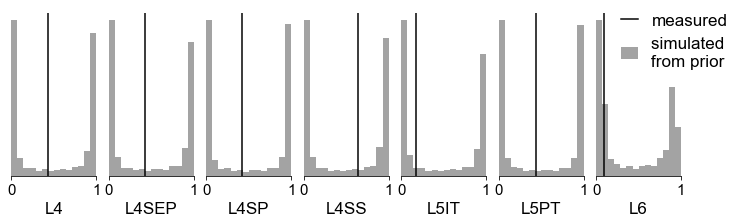

In [43]:
fig, ax = plt.subplots(1, 7, figsize=(12, 3), gridspec_kw=dict(wspace=0.15))
xo = np.array([[0.4300, 0.4300, 0.4200, 0.6400, 0.1700, 0.4400, 0.0900]])

colors = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
data_labels = [r"L4", r"L4SEP", r"L4SP", r"L4SS", r"L5IT", r"L5PT", r"L6"]
num_bins = 15

for ii in range(7):
    plt.sca(ax[ii])
    plt.hist(xs[:, ii].numpy(), color=colors[6], 
             bins=np.linspace(0, 1, num_bins), 
             density=True,
             alpha=0.9)
    plt.axvline(xo[0, ii], color="k")
    plt.xticks(np.linspace(0,1,2))
    plt.xlim(0, 1)
    ax[ii].spines["right"].set_visible(False)
    ax[ii].spines["top"].set_visible(False)
    ax[ii].spines["left"].set_visible(False)
    plt.yticks([])
    plt.xlabel(data_labels[ii])
plt.legend(["measured", "simulated \nfrom prior"], bbox_to_anchor=(.11, .56), handlelength=1.0);

In [ ]:
fig.savefig("prior_predictive_dso.png", dpi=300, bbox_inches='tight')

## Result

The simulations with parameters sampled from the prior shown above cover the entire range of possible probability values. They also seem to contain the measurements. 

This is exactly what we need for running SBI: Among the many different parameter combinations simulated above, SBI will help us to find those combinations that result in data similar to the measurements.

See the `2_inference` notebook for details.

## Distance based rules

The second example show in the paper are wiring rules that form connections solely based on how close the neurons are to each other. 

There two variants:
 - one that acts at the neuron-level, simulating connections for every neuron pair
 - and one that acts at the subcellular level, simulating connections (synapses) for each neuron-pair in every subvolume.

Both variants can be applied at different levels of resolution of the structural model, i.e., the side length of the subvolume (cube size).

### Neuron level
The neuron level rule has its own class for simulating corresponding connectomes: `DistanceRuleSimulator`. 
There are different sets of structural features: set 6 for the neuron level, and set 7 for the synapse level.

Similarly, there are different rule functions and features that need to be passed to the simulator: 
    - number of `common_cubes` as features and the `cutoff_rule` as rule for the neuron level
    - for the synapse level rule, there is a separate function `rule_subcellular`

### Synapse level
However, the synapse level rule, because it has ixjxk entries to simulate, can be very slow in this simple implementation without prelocation. Thus, for simulating the synapse level rule we return to the original simulator `RuleSimulator`.

### Neuron level

using feature set-6


Text(0, 0.5, 'count')

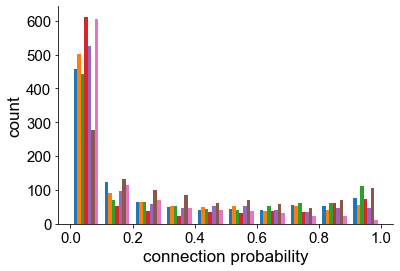

In [47]:
path_to_model = str(DATA_PATH.joinpath("cube_model"))
# set number of neuron pairs sampled from the connectome to mimick experimental settings, e.g., 50
num_subsampling_pairs = 50
cube_size = 50
num_simulations = 1000

# Select feature sets:
#     "set-7"  # holds subcellular level features: 1 if two neurons meet in a voxel, 0 else., ixjxk entries
#     "set-6"  # Set 6 holds the common cubes for different cube sizes. ixj entries
#     "set-5"  # Set 5 holds common cubes, min distance and axon-dendrite product for cube size 50mu-m

prior = BoxUniform(torch.zeros(1), torch.ones(1) * 100)
model = DistanceRuleSimulator(path_to_model,
                              feature_set_name="set-6", 
                              num_subsampling_pairs=num_subsampling_pairs, 
                              cube_size=cube_size)

def batch_simulator(theta):
    return model.rule(theta, 
        feature=model.common_cubes, #  Corresponds to feature set 6.
        connection_fun=model.cutoff_rule  # cutoff rule forms a connection when feature crosses a threshold.
    )


theta, x = simulate_for_sbi(batch_simulator, prior, num_simulations=num_simulations, num_workers=1)

plt.hist(x.numpy())
plt.xlabel("connection probability")
plt.ylabel("count");

### Visualization

Here, we chose a compact version of visualizing the seven connection probabilities: we show of the seven values as bar plot across the interval `[0, 1]`. 

It is good if the bars are relatively similar in height, corresponding to a balanced prior predictive distribution. 

### Synapse level 

In [48]:
path_to_model = str(DATA_PATH.joinpath("subcellular_features"))
# set number of neuron pairs sampled from the connectome to mimick experimental settings, e.g., 50
num_subsampling_pairs = 50
cube_size = 1
num_simulations = 1000

prior = torch.distributions.Beta(
    concentration1=torch.ones(1) * 0.5, concentration0=torch.ones(1) * 0.5
)

simulator = RuleSimulator(
    path_to_model,
    peters_rule_subcellular,
    verbose=False,
    num_subsampling_pairs=num_subsampling_pairs,
    experiment_name="peters-subcellular",
)
batch_simulator, prior = prepare_for_sbi(simulator, prior)

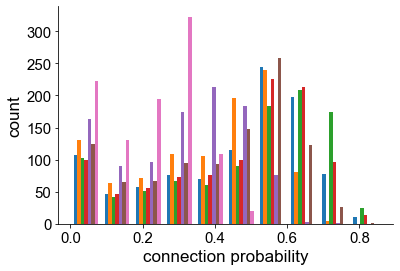

In [49]:
theta, x = simulate_for_sbi(batch_simulator, prior, num_simulations=num_simulations, num_workers=1)
plt.hist(x.numpy())
plt.xlabel("connection probability")
plt.ylabel("count");

## Poisson GLM

Running the poisson GLM simulator corresponds to applying the rule to a small set of structural features and sampling from a Poisson distribution with the resulting rates. Thus, it very fast to set up and ideal for testing: 

In [51]:
theta.shape

torch.Size([10000, 1])

In [52]:
prior = MultivariateNormal(torch.ones(3), 0.5 * torch.eye(3))
theta = prior.sample((10000,))
x = poisson_glm(theta)

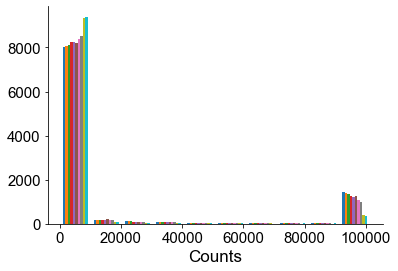

In [53]:
plt.hist(x.numpy())
plt.xlabel("Counts");